## Path sampling: Brownian motion prior, brownian bridge posterior

This notebook contains the code for Example [TODO].

In this example, we condition a Brownian motion with diffusion coefficient \sqrt{2}, starting at x(0)=-2, so it hits +2 at T=1, i.e., x(1)=+2. This is a prior -> posterior transport.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
import sys 
sys.path.append('../src/')
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)

from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy

from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## We implement our NN annealing approach Algorithm 1 without SPDE below

[0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5        0.57142857 0.64285714 0.71428571 0.78571429
 0.85714286 0.92857143 1.        ]
s:  0.0
Train loss: 71224352.0
s:  0.0
Train loss: 72405704.0
s:  0.07142857142857142
Train loss: 333504896.0
s:  0.14285714285714285
Train loss: 4896281.5
s:  0.21428571428571427
Train loss: 1641256.25
s:  0.2857142857142857
Train loss: 1034709.4375
s:  0.3571428571428571
Train loss: 568306.75
s:  0.42857142857142855
Train loss: 285195.34375
s:  0.5
Train loss: 126752.140625
s:  0.5714285714285714
Train loss: 87534.765625
s:  0.6428571428571428
Train loss: 43264.953125
s:  0.7142857142857142
Train loss: 53581.7265625
s:  0.7857142857142857
Train loss: 41940.390625
s:  0.8571428571428571
Train loss: 44497.546875
s:  0.9285714285714285
Train loss: 34412.859375


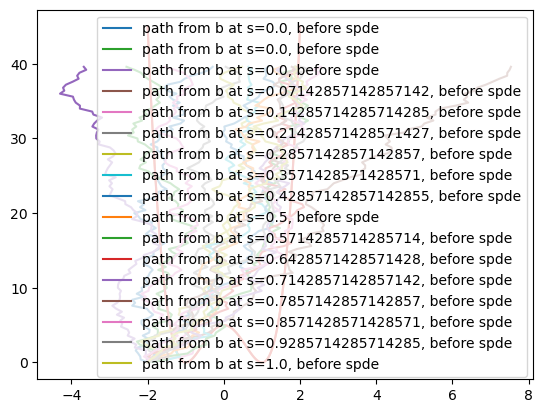

In [2]:
key = jax.random.key(0)
schedule = np.linspace(0,1,15)   # schedule for s
print(schedule)


ndims = 1

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200, 'batch_size' : 500}


# b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
b = lambda x, t: 0.0    # prior drift
A = 0
dbds = MLP([3,30,30,20,1], key=jax.random.key(1))
B = 2.0   # endpoint location

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=lambda x: 0.0,   # prior potential, in this case Brownian motion with V(x)=0
        b=b, 
        J=lambda x,y: (1.0/2)*(1/0.1**2)*(x[-1,0]- B)**2,   # sigma = 0.1
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        rho = lambda key: jnp.zeros((1,))-2.,
        refine=False
    )



## Use the final learned b to generate paths from the target

In [3]:
#from path_sampling import make_b


# use this if we do amortized nn
# b = make_b(schedule[:i], uref, dbds)

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))


# xs : [batch_size, num_steps, ndims]
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-2.0,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))

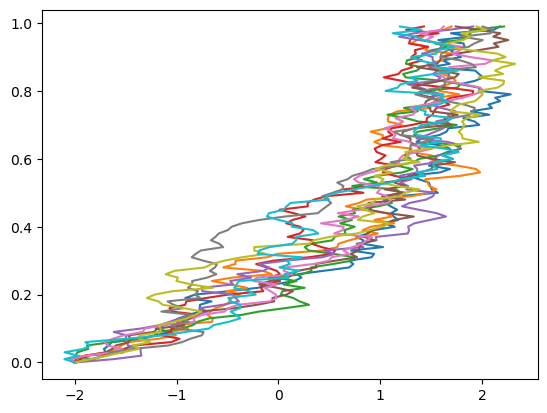

In [4]:
for path in xs:
    plt.plot(path, times[0])

# Rerun Algorithm 1 with SPDE turned on 


[0.1]
s:  0.0
Train loss: nan


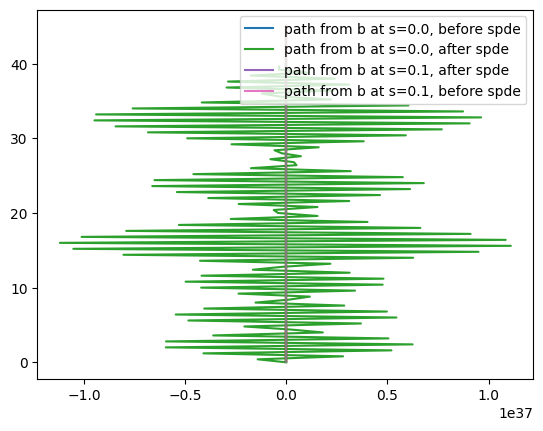

In [4]:
key = jax.random.key(0)
# schedule = np.linspace(0,1,11)   # schedule for s
schedule = [0.1]   # schedule for s
print(schedule)


ndims = 1

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200, 'batch_size' : 500}


# b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
b = lambda x, t: 0.0    # prior drift
A = 0
B = 2.0   # endpoint location

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)
    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=lambda x: 0.0,   # prior potential, in this case Brownian motion with V(x)=0
        b=b, 
        J=lambda x,y: (1.0/2)*(1/0.1**2)*(x[-2,0]- B)**2,   # sigma = 0.1, condition on second-to-last point = +2
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        rho = lambda key: jnp.zeros((1,))-2.,   #initial point
        refine=True   # default is 30 SPDE steps between every s -> s+\delta_s, with inner stepsize=0.001 for SPDE
    )



## And plot the resulting new paths below

In [ ]:

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))


# xs : [batch_size, num_steps, ndims]
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-2.0,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))

for path in xs:
    plt.plot(path, times[0])

# Compare to exact brownian bridge

We now generate random paths by simulating the Brownian Bridge SDE with a drift term `b=\frac{B-X_t}{T-t}` and a diffusion term `W=\sqrt{2}dW_t`, where $B=2$ is the target, $T=1$, initialized from $x_0=-2$.

This is regarded as the ground truth for this example.

In [ ]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200}
B = 2.0


paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (B - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-2.,   # initial point
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 10))

# visualize path
for path, time in zip(paths, times):
    plt.plot(path,time)
    
# plot potential
x = np.linspace(-2.5, 2.5, 100)

# red to green colormap
# Create a colormap from red to green
cmap = plt.cm.RdYlGn
colors = cmap(np.linspace(0, 1, len(paths)))

# Plot each path with a color from the gradient
for i, (path, time) in enumerate(zip(paths, times)):
    plt.plot(path, time, color=colors[i])
    
# Plot the potential
# plt.plot(x, potential(x[:, None]), 'k--', alpha=0.7)  # Plot potential as dashed black line